# Data Pipeline
Initial data analysis pipeline including a naive sentiment analysis using TextBlob.

In [1]:
import re
import spacy
import pandas as pd
import numpy as np
from pathlib import Path
from string import punctuation

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import calmap # for making GitHub-style calendar plots of time-series
# Plot using Pandas datatime objects
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
rc_fonts = {'figure.figsize': (15, 8),
            'axes.labelsize': 16,
            'xtick.labelsize': 14,
            'ytick.labelsize': 14}
plt.rcParams.update(rc_fonts)
plt.style.use('ggplot')

In [4]:
# Scikit-learn for TF-IDF and similarity detection
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS

## Use ```spaCy``` for tokenization and sentence segmentation

In [5]:
import spacy
from spacy import displacy
# Load spaCy language model (blank model to which we add pipeline components)
sentencizer = spacy.blank('en')
sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))

#### Specify named entity of interest

In [6]:
name = "Ryan Lochte"

#### Write data: Boolean
Specify if we want to write the output data to csv or not.

In [7]:
write_ = False

In [8]:
datafile = 'all_the_news_v2.csv'
datapath = Path('../') / 'data' / datafile 
colnames = ['title', 'author', 'date', 'content', 'year', 'month', 'publication', 'length']

news = pd.read_csv(datapath, usecols=colnames, parse_dates=['date'])
news['author'] = news['author'].str.strip()
news.head()

,title,author,date,content,year,month,publication,length
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,2017-05-31,And never more so than in Showtime’s new...,2017.0,5.0,Verge,2376
1,"AI, the humanity!",Sam Byford,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Verge,2125
2,The Viral Machine,Kaitlyn Tiffany,2017-05-25,Super Deluxe built a weird internet empi...,2017.0,5.0,Verge,3310
3,How Anker is beating Apple and Samsung at thei...,Nick Statt,2017-05-22,Steven Yang quit his job at Google in th...,2017.0,5.0,Verge,3632
4,Tour Black Panther’s reimagined homeland with ...,Kwame Opam,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017.0,5.0,Verge,262


In [9]:
news = news.dropna(subset=['date', 'title'])
news.shape[0]

143156

In [10]:
news['date'].describe()

count                  143156
unique                   1480
top       2017-01-13 00:00:00
freq                      415
first     2000-05-15 00:00:00
last      2017-07-05 00:00:00
Name: date, dtype: object

### Filter articles based on name match
In this section we only select those news articles that contain part of or all of the name we input as ```name```.

In [11]:
def check_name(content, name):
    flag = False
    if name in content:
        flag = True
    return flag

def filter_df(df):
    df['match'] = df['content'].apply(lambda x: check_name(x, name))
    df_relevant = df.loc[df['match'].eq(True)]
    return df_relevant.drop(['match'], axis=1)

news_relevant = filter_df(news)
print(news_relevant.shape[0])
news_relevant.head()

182


,title,author,date,content,year,month,publication,length
3095,"After Olympic-sized goof, Ryan Lochte begins a...",David Wharton,2017-04-27,Don’t cringe or shake your head or stop readin...,2017.0,4.0,Los Angeles Times,1925
8946,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996
13789,Michael Phelps Powers U.S. to Victory in 4x100...,"Victor Mather, Karen Crouse and Doug Mills",2016-08-10,RIO DE JANEIRO — Michael Phelps won his 19th O...,2016.0,8.0,New York Times,276
13825,Rio Olympics: Simone Manuel Makes History in t...,Karen Crouse,2016-08-16,RIO DE JANEIRO — Simone Manuel managed to make...,2016.0,8.0,New York Times,1468
13839,"Rio Olympics: A Phelps Upset, a Judo Snub, and...",Sam Manchester and Victor Mather,2016-08-16,Katie Ledecky did what Katie Ledecky does best...,2016.0,8.0,New York Times,1614


### Perform sentence segmentation
Store the sentences in each news articles as a list of sentences, from which we can easily extract per-sentence sentiment.

In [12]:
def get_relevant(text, name):
    doc = sentencizer(text)
    relevant = []
    for sent in doc.sents:
        for n in name.split():
            if n in sent.text:
                clean = sent.text.replace("\n", " ").replace("\xa0", " ")
                # Strip bad characters at the start of sentences
                clean = clean.strip("[\'").strip("\']").strip('\"').strip("\'\"")
                clean = clean.strip(",\'").strip("\',").strip('\"').strip("\'\"").strip()
                relevant.append(clean)
    # Remove duplicates
    relevant = list(dict.fromkeys(relevant))
    return relevant

In [13]:
news_relevant['relevant'] = news_relevant['content'].apply(lambda x: get_relevant(x, name))

In [14]:
for i in news_relevant['relevant'][:5]:
    print(i, '\n--')

["That’s all Ryan Lochte wants as he ambles across the pool deck on a bright Southern California day, looking tanned and relaxed, if a bit weary from his morning workout.', '“", 'Lochte now finds himself living in Los Angeles with his pregnant fiancée and training at USC with thoughts of a comeback.', "Here’s the condensed version:', 'After a fifth-place finish in the 200-meter individual medley — his dissatisfaction hardly assuaged by a gold in the 800 freestyle relay — Lochte partied with three teammates at the French team’s hospitality house.',", "Lochte initially told authorities they were pulled over and robbed by armed men posing as police officers.',", "Lochte suffered an additional blow as Speedo and other corporate sponsors walked away.',", 'Ryan Lochte didn’t have to get drunk and vandalize a Rio de Janeiro gas station during the Summer Olympics in August.', "But he did, and it’s at times like this when people really need their...', 'Ryan Lochte didn’t have to get drunk and v

### Sentiment scoring using FastText

In [15]:
import fastText
# Load trained fastText model
model_path = './fasttext_models/pretrained_yelp_review_full.ftz'

#### Preprocess text and tokenize as per FastText requirements

In [16]:
def fasttext_tokenize(string):
    string = string.lower()
    string = re.sub(r"([.!?,'/()])", r" \1 ", string)
    return string

In [17]:
# reviews = [
#     "This restaurant literally changed my life. This is the best food I've ever eaten!",
#     "I hate this place so much. They were mean to me.",
#     "I don't know. It was ok, I guess. Not really sure what to say.",
# ]

# preprocessed_reviews = list(map(strip_formatting, reviews))
# # Load classifier
# classifier = fastText.load_model(model_path)

# # Get fastText to classify each review with the model
# labels, probabilities = classifier.predict(preprocessed_reviews, 1)
# stars = [int(l[0][-1]) - 3 for l in labels]
# stars

In [18]:
classifier = fastText.load_model(model_path)
def get_score_fasttext(text_list):
    # Calculate polarity for each sentence
    preprocessed = list(map(fasttext_tokenize, text_list))
    labels, probabilities = classifier.predict(preprocessed, 1)
    sentiment_list = [(int(l[0][-1]) - 3)/2 for l in labels if l]
    score = np.mean(sentiment_list)
    deviation = np.std(sentiment_list)
    return score, deviation

In [19]:
news_relevant['score'], news_relevant['deviation'] = zip(*news_relevant['relevant'].map(get_score_fasttext))
news_relevant.head(5)

,title,author,date,content,year,month,publication,length,relevant,score,deviation
3095,"After Olympic-sized goof, Ryan Lochte begins a...",David Wharton,2017-04-27,Don’t cringe or shake your head or stop readin...,2017.0,4.0,Los Angeles Times,1925,[That’s all Ryan Lochte wants as he ambles acr...,-0.236842,0.63595
8946,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996,"[Ryan Lochte, another preeminent American swim...",0.250000,0.25000
13789,Michael Phelps Powers U.S. to Victory in 4x100...,"Victor Mather, Karen Crouse and Doug Mills",2016-08-10,RIO DE JANEIRO — Michael Phelps won his 19th O...,2016.0,8.0,New York Times,276,[Ryan Held and Nathan Adrian brought the U.S. ...,0.750000,0.25000
13825,Rio Olympics: Simone Manuel Makes History in t...,Karen Crouse,2016-08-16,RIO DE JANEIRO — Simone Manuel managed to make...,2016.0,8.0,New York Times,1468,[Michael Phelps won the 200 individual medley ...,0.750000,0.25000
13839,"Rio Olympics: A Phelps Upset, a Judo Snub, and...",Sam Manchester and Victor Mather,2016-08-16,Katie Ledecky did what Katie Ledecky does best...,2016.0,8.0,New York Times,1614,[Phelps Breaks an Ancient Record: Michael Phel...,0.750000,0.25000


### Lemmatize relevant sentences for comparison
This is to remove duplicates.

In [20]:
add_removed_words = {n for n in name.split()}
# Include specific words to be removed
stopwords = sentencizer.Defaults.stop_words
stopwords = stopwords.union(add_removed_words)

In [21]:
# Tokenize and lemmatize text
def lemmatize(text):
    doc = sentencizer(text)
    tokens = [str(tok.lemma_).lower() for tok in doc if tok.text not in stopwords \
              and tok.text not in punctuation]
    return tokens

In [22]:
news_relevant['lemmas'] = news_relevant['relevant'].str.join(' ').apply(lemmatize).str.join(' ')
news_relevant[['relevant', 'lemmas']].head()

,relevant,lemmas
3095,[That’s all Ryan Lochte wants as he ambles acr...,that ’s want amble pool deck bright southern c...
8946,"[Ryan Lochte, another preeminent American swim...",preeminent american swimmer finish 5 52.21 but...
13789,[Ryan Held and Nathan Adrian brought the U.S. ...,held nathan adrian bring u.s. home adrian ’s s...
13825,[Michael Phelps won the 200 individual medley ...,michael phelps win 200 individual medley easil...
13839,[Phelps Breaks an Ancient Record: Michael Phel...,phelps breaks ancient record michael phelps wi...


### Drop duplicates

In [23]:
news_relevant = news_relevant.drop_duplicates(subset=['lemmas'])
news_relevant.shape[0]

161

#### Positive sentiment group

In [24]:
pos = news_relevant[news_relevant['score'] > 0.0].sort_values(by=['score'], ascending=False).reset_index(drop=True)
print("Found {} overall positive articles for {}".format(pos.shape[0], name))
pos.head(3)

Found 33 overall positive articles for Ryan Lochte


,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas
0,The Atlantic Daily: A Whole New World,Rosa Inocencio Smith,2016-08-24,[ For us to continue writing great stor...,2016.0,8.0,Atlantic,1201,"[Thirsty snakes swim, doctors improvise, money...",1.0,0.0,thirsty snake swim doctor improvise money trai...
1,"Rio Olympics: U.S. Basketball, Swimmers Detain...",Andrew Keh,2016-08-22,RIO DE JANEIRO — The Argentine fans were wavin...,2016.0,8.0,New York Times,1186,"[Earlier, a Brazilian judge issued an order to...",1.0,0.0,earlier brazilian judge issue order prevent ja...
2,Team Hillary lands on ‘least influential’ list...,Daniel Halper,2016-12-22,"My, how the mighty have fallen. Hillary Clinto...",2016.0,12.0,New York Post,221,"[Also on the list are Peyton Manning, Matt Lau...",1.0,0.0,also list peyton manning matt lauer harambe al...


#### Write positive results

In [25]:
if write_:
    out_filename = '_'.join(name.split()).lower() + '_pos.csv'
    out_path = Path('./') / "results/fasttext" / out_filename
    pos.sort_values(by='publication')[['publication', 'title', 'date', 'relevant', 'score', 'deviation']] \
                    .to_csv(out_path, index=False, header=True)

#### Negative sentiment group

In [26]:
neg = news_relevant[news_relevant['score'] < 0.0].sort_values(by=['score']).reset_index(drop=True)
print("Found {} overall negative articles for {}".format(neg.shape[0], name))
neg.head(3)

Found 104 overall negative articles for Ryan Lochte


,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas
0,The Atlantic Politics & Policy Daily: Electio...,Candice Norwood,2016-08-18,[ For us to continue writing great stor...,2016.0,8.0,Atlantic,769,[Brazilian authorities said four American Olym...,-1.0,0.0,brazilian authority say american olympic swimm...
1,All of Ryan Lochte's sponsors have dropped him,Mallory Schlossberg,2016-08-23,"['\n\n', ""\n Speedo \n Monday that it will n...",2016.0,8.0,Business Insider,270,"[\n\n', ""\n Speedo \n Monday that it will no...",-1.0,0.0,\n\n \n speedo \n monday long sponsor ther...
2,The Rio Olympics: A Crib Sheet,The Editors,2016-08-18,[ For us to continue writing great stor...,2016.0,8.0,Atlantic,1416,"[The Ugly: On Sunday, the American swimmer Rya...",-1.0,0.0,the ugly on sunday american swimmer claim alon...


#### Write negative results

In [27]:
if write_:
    out_filename = '_'.join(name.split()).lower() + '_neg.csv'
    out_path = Path('./') / "results/fasttext" / out_filename
    neg.sort_values(by='publication')[['publication', 'title', 'date', 'relevant', 'score', 'deviation']] \
                    .to_csv(out_path, index=False, header=True)

In [28]:
mixed = news_relevant[news_relevant['score'] == 0.0].reset_index(drop=True)
print("Found {} overall mixed articles for {}".format(mixed.shape[0], name))
mixed.head(3)

Found 24 overall mixed articles for Ryan Lochte


,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas
0,"Halloween, Instagram Style - The New York Times",Bonnie Wertheim,2016-11-01,Last night Eleven from “Stranger Things” and t...,2016.0,11.0,New York Times,336,"[Ryan Lochte’s silver Olympic hair, among his ...",0.0,0.0,’s silver olympic hair rio 2016 antic swimmer ...
1,"Zika, U.S. Presidential Race, Ryan Lochte: You...",Andrea Kannapell and Sandra Stevenson,2016-08-22,(Want to get this briefing by email? Here’s th...,2016.0,8.0,New York Times,940,[I want to apologize for my behavior last week...,0.0,0.0,i want apologize behavior weekend -- careful c...
2,"U.S. Presidential Race, Ryan Lochte, Rio de Ja...",Andrea Kannapell and Hiroko Masuike,2016-08-22,(Want to get this briefing by email? Here’s th...,2016.0,8.0,New York Times,797,[One big loser: Ryan Lochte.],0.0,0.0,one big loser


### Highlight relevant named entities using ```spaCy```
Optional step to observe the key named entities in the positive/negative or mixed sentiment articles. 

In [29]:
from IPython.display import Markdown, display
options = {'ents': ['PERSON', 'ORG', 'GPE', 'EVENT'], 
           'colors': {'PERSON': '#9fafe5', 'ORG': '#d59b9b', 'GPE':'#81cba6'}}
def printmd(string):
    display(Markdown(string))
    
def display_entities(nlp, df, max_entries=5):
    # Set relevant named entities that we want to extract
    for idx, sent in enumerate(df['relevant'].str.join(' ')[:max_entries]):
        doc = nlp(sent)
        printmd('**{}**'.format(df['title'][idx]))
        displacy.render(doc, style='ent', jupyter=True, options=options)
        print('\n')
        
def vis(pos, neg, mixed, spacy_lang='en_core_web_md'):
    nlp = spacy.load(spacy_lang)
    # Visualize positive and negativ groups using markdown
    printmd('<font color=green>**Positive**</font>')
    display_entities(nlp, pos)
    printmd('<font color=red>**Negative**</font>')
    display_entities(nlp, neg)
    printmd('<font color=yellow>**Mixed**</font>')
    display_entities(nlp, mixed)

In [30]:
# vis(pos, neg, mixed, spacy_lang='en_core_web_md')

## Visualization

### Plot sentiment score and magnitude versus time of publishing of the article
In this section, sentiment "score" is the median of all polarity values (positive or negative) obtained per-sentence of the article from TextBlob. Sentiment "magnitude" is the standard deviation of sentiment among the per-sentence polarity values. 

In [31]:
news_avg_score = news_relevant.groupby('date')['score'].mean()
news_avg_dev = news_relevant.groupby('date')['deviation'].mean()

#### Get article count per day

In [32]:
news_count = news_relevant.groupby(['date']).count()['title']

#### Get peak polar article per day (min negative or max positive score)

In [33]:
news_relevant['abs'] = news_relevant['score'].abs()
news_relevant[['date', 'score', 'abs']].head(3)

,date,score,abs
3095,2017-04-27,-0.236842,0.236842
8946,2014-08-08,0.250000,0.250000
13789,2016-08-10,0.750000,0.750000


In [34]:
news_relevant[(news_relevant['date'] > '2016-08-14') & (news_relevant['date'] < '2016-08-17')].head(10)

,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas,abs
13825,Rio Olympics: Simone Manuel Makes History in t...,Karen Crouse,2016-08-16,RIO DE JANEIRO — Simone Manuel managed to make...,2016.0,8.0,New York Times,1468,[Michael Phelps won the 200 individual medley ...,0.750000,0.250000,michael phelps win 200 individual medley easil...,0.750000
13839,"Rio Olympics: A Phelps Upset, a Judo Snub, and...",Sam Manchester and Victor Mather,2016-08-16,Katie Ledecky did what Katie Ledecky does best...,2016.0,8.0,New York Times,1614,[Phelps Breaks an Ancient Record: Michael Phel...,0.750000,0.250000,phelps breaks ancient record michael phelps wi...,0.750000
34849,Rio Officials Turn on Ryan Lochte After Robber...,Frances Martel,2016-08-16,Rio de Janeiro police officials and Olympics o...,2016.0,8.0,Breitbart,745,[Rio de Janeiro police officials and Olympics ...,-0.958333,0.138193,rio de janeiro police official olympic organiz...,0.958333
59641,American swimmer Ryan Lochte and 3 others were...,Cork Gaines,2016-08-15,"['\n\n', '\n [UPDATE] The United States Olymp...",2016.0,8.0,Business Insider,442,"[\n\n', '\n [UPDATE] The United States Olympi...",-0.250000,0.829156,\n\n \n update the united states olympic com...,0.250000
67063,The Rio Olympics: A Crib Sheet,The Editors,2016-08-15,[ For us to continue writing great stor...,2016.0,8.0,Atlantic,1309,[The Ugly: The American swimmer Ryan Lochte ha...,0.000000,0.707107,the ugly the american swimmer successful games...,0.000000
131760,"Far From Olympics, Violence Rises In Rio's Poo...",Lulu Garcia-Navarro,2016-08-15,"[""That bullet almost hit my bed. Have mercy, p...",2016.0,8.0,NPR,889,[While media attention has focused on U.S. Oly...,-1.000000,0.000000,while medium attention focus u.s. olympic swim...,1.000000


In [35]:
news_peak_polar = news_relevant.groupby('date').max()[['title', 'publication', 'relevant']]
# Extract just the first 3 relevant sentences from the article and convert to single string
news_peak_polar['relevant'] = news_peak_polar['relevant'].apply(lambda x: x[:3]).str.join(' ')
print(news_peak_polar.shape[0])

58


#### Combine scores, magnitudes and article counts per day

In [36]:
scores = pd.concat((news_avg_score, news_avg_dev, news_count), axis=1).sort_values(by=['date'])
scores.columns = ['mean_score', 'mean_dev', 'count']
scores.head()

,mean_score,mean_dev,count
date,,,
2014-08-08,0.250000,0.250000,1
2016-06-27,-0.305556,0.818856,1
2016-08-05,-0.125000,0.375000,2
2016-08-06,0.000000,0.000000,1
2016-08-07,-0.500000,0.000000,1


#### Concatenate scores/counts DataFrame with most polar news content for that day

In [37]:
data = pd.concat((news_peak_polar, scores), axis=1).sort_index()
data.head()

,title,publication,relevant,mean_score,mean_dev,count
date,,,,,,
2014-08-08,Michael Phelps is a touch off in 100 butterfly...,Los Angeles Times,"Ryan Lochte, another preeminent American swimm...",0.250000,0.250000,1
2016-06-27,"Ryan Lochte, ’12 Olympic Champion, Misses Rio ...",New York Times,OMAHA — Ryan Lochte was off to a rough start a...,-0.305556,0.818856,1
2016-08-05,The Rio Olympics: Catch the Fever!,New York Post,"Swimmer Ryan Lochte, a regular poster boy in O...",-0.125000,0.375000,2
2016-08-06,The Cultural Marxism of Rio’s Opening Ceremonies,National Review,Ryan Lochte and America’s Man-Boy ProblemAmeri...,0.000000,0.000000,1
2016-08-07,"Hey, Watch This",National Review,Ryan Lochte and America’s Man-Boy ProblemAmeri...,-0.500000,0.000000,1


#### Reindex data to show daily scores
Since we have really sparse data (news articles about the target are not written every day, we reindex the time series and fill missing values with zeros. 

In [38]:
idx = pd.date_range('1/1/2014', '7/5/2017')
daily = data.reindex(idx, fill_value=0.0)

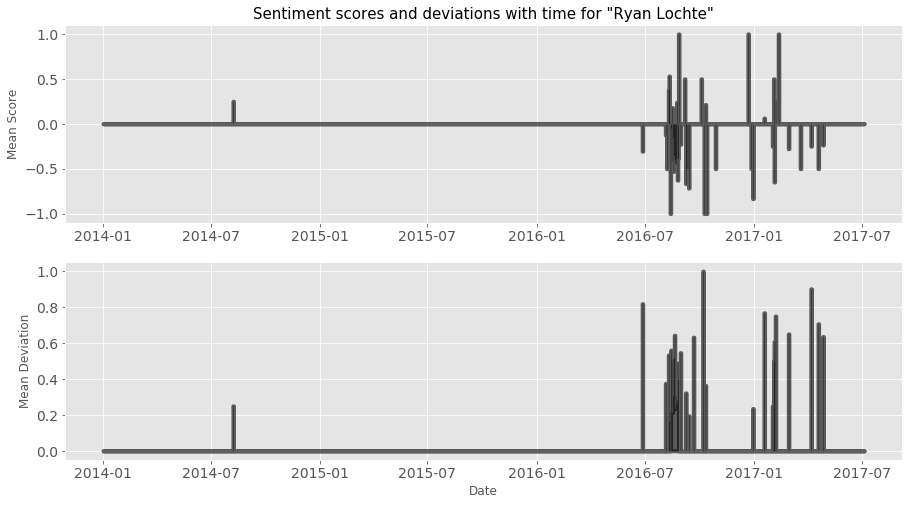

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.fill_between(daily.index, daily['mean_score'], step='mid', color='black', alpha=0.6, linewidth=4);
ax1.set_ylabel('Mean Score');
ax1.set_title('Sentiment scores and deviations with time for "{}"'.format(name), size=15);
ax2.fill_between(daily.index, daily['mean_dev'], step='mid', color='black', alpha=0.6, linewidth=4);
ax2.set_ylabel('Mean Deviation');
ax2.set_xlabel('Date');
# plt.savefig("{}_scores".format('_'.join(name.split()).lower()))

#### Make calendar plot to show periods of activity

/home/pprao/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


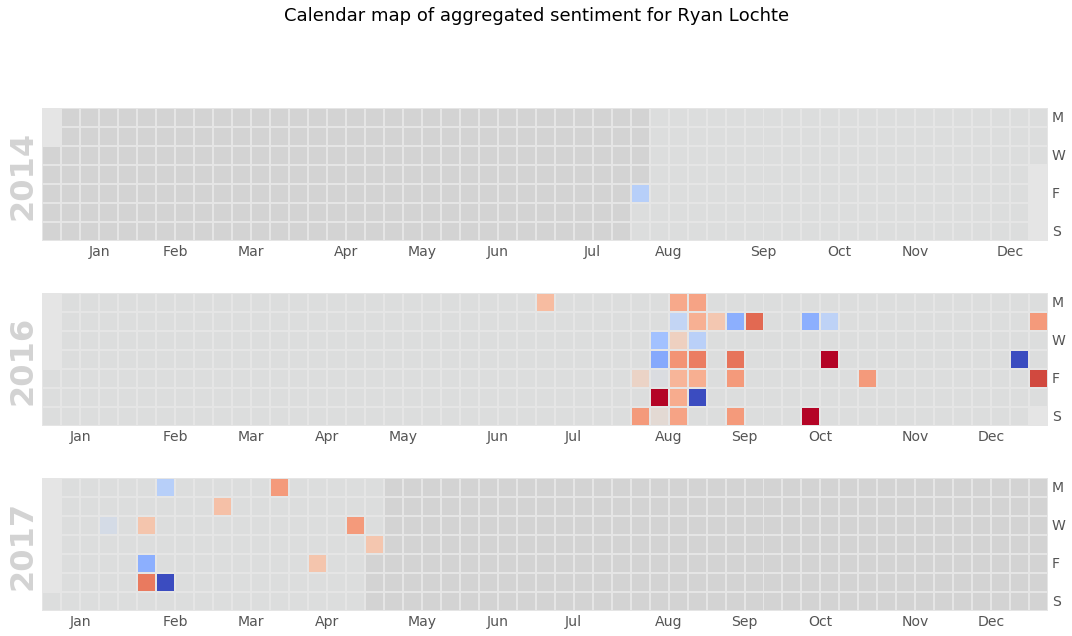

In [40]:
fig, axes = calmap.calendarplot(data['mean_score'],
                    vmin = -1.0,
                    vmax=1.0,
                    daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    fig_kws=dict(figsize=(15, 10)),
                    linewidth=1,
                    fillcolor='lightgrey',
                    cmap='coolwarm_r',
                   );
fig.suptitle("Calendar map of aggregated sentiment for {}".format(name), fontsize=18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

if write_:
    out_filename = '_'.join(name.split()).lower()
    plt.savefig('calmap_{}.png'.format(out_filename))

#### Get counts of positive and negative mentions based on Publication

In [41]:
grouped = news_relevant.groupby('publication').apply(lambda x: x['score'] >= 0.0)
grouped = grouped.groupby('publication').value_counts().to_frame()
grouped = grouped.unstack().fillna(0.0)
grouped.columns = ['Negative', 'Positive']
grouped = grouped.sort_values(by='Negative')
grouped

,Negative,Positive
publication,,
Los Angeles Times,1.0,1.0
National Review,2.0,5.0
Reuters,3.0,1.0
Business Insider,4.0,2.0
Fox News,6.0,6.0
New York Post,6.0,6.0
Breitbart,7.0,0.0
Guardian,7.0,7.0
Buzzfeed News,10.0,1.0


#### Plot article breakdown

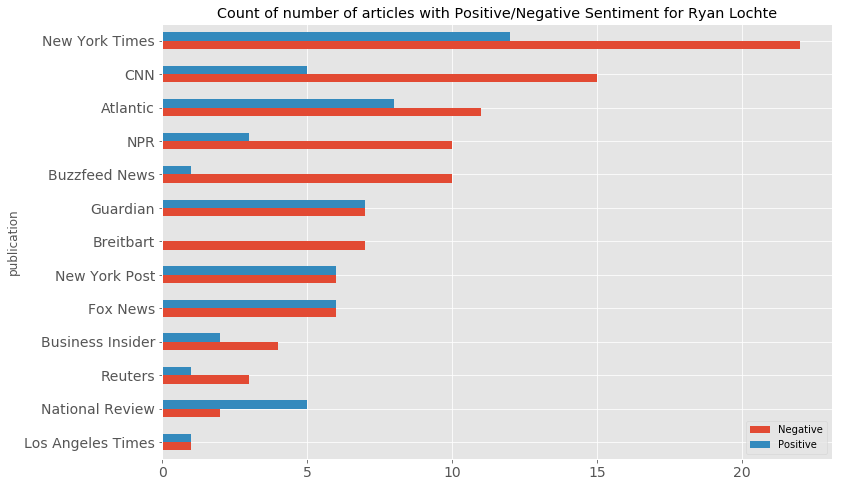

In [42]:
grouped.plot(kind='barh', figsize=(12, 8));
plt.title('Count of number of articles with Positive/Negative Sentiment for {}'.format(name));
# plt.savefig("{}_breakdown".format('_'.join(name.split()).lower()))

#### Output results to CSV

In [43]:
if write_:
    out_filename = '_'.join(name.split()).lower() + '_breakdown.csv'
    out_path = Path('./') / "results/fasttext" / out_filename
    grouped.to_csv(out_path, header=True)

In [44]:
if write_: 
    data_filename = '_'.join(name.split()).lower() + '_data.csv'
    data_path = Path('./') / "results/fasttext" / data_filename
    daily[~daily['relevant'].eq(0)].to_csv(data_path, header=True)

## Visualize Cosine Similarity Distances
To see how similar or different each article is based on publication, we can compute the cosine distances between articles to generate a "distance matrix" and then visualize these distances in two-dimensional space.

#### Calculate TF-IDF for document similarity
We first define the term frequency-inverse document frequency to vectorize the text for each article into parameters, and generate a ```tf-idf``` matrix. 

Once we compute the ```tf-idf``` matrix, we can find a "distance matrix" that stores how similar or how different two documents are.

In [45]:
# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2)
# 
tfidf_matrix = tfidf_vectorizer.fit_transform(news_relevant['lemmas'] ) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

# Display some key terms
terms = tfidf_vectorizer.get_feature_names()

(161, 37)


In [46]:
# Get cosine distance matrix
dist = 1 - cosine_similarity(tfidf_matrix)

#### Multidimensional Scaling (MDS)
The computed distances are in multi-dimensional in nature. To visualize the similarity, we "embed" the cosine distances (from the distance matrix) to a two-dimensional space, which we can then plot to see how the articles compare with each other in terms of their content.

In [47]:
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=37)
dist_transformed = embedding.fit_transform(dist)
print(dist_transformed.shape)

xs, ys = dist_transformed[:, 0], dist_transformed[:, 1]

(161, 2)


#### Generate an MDS DataFrame for plotting
We combine the x-y distances from the MDS calculation with the original publication labels to see how different the articles are from each other, colored by publication.

In [48]:
compare = pd.DataFrame(dict(label=news_relevant['publication'], x=xs, y=ys))
compare.head()

,label,x,y
3095,Los Angeles Times,0.049449,0.029639
8946,Los Angeles Times,0.035553,-0.470827
13789,New York Times,0.569741,-0.192691
13825,New York Times,0.679005,0.406072
13839,New York Times,-0.364867,0.741446


In [49]:
L = news_relevant['publication'].nunique()
print("Found {} unique categories for publications".format(L))

Found 13 unique categories for publications


In [50]:
groups = compare.groupby('label').agg({'label': 'count', 'x': 'mean', 'y': 'mean'})
groups.columns = ['count', 'x', 'y']
groups = groups.sort_values(by='count')
groups

,count,x,y
label,,,
Los Angeles Times,2,0.042501,-0.220594
Reuters,4,0.181835,0.172886
Business Insider,6,0.012952,0.141242
Breitbart,7,-0.034057,-0.010643
National Review,7,0.144999,0.477238
Buzzfeed News,11,-0.121611,-0.023451
Fox News,12,-0.031457,0.166461
New York Post,12,-0.027713,-0.109907
NPR,13,0.086689,0.215968


#### Visualize similarities as embedded cosine distances

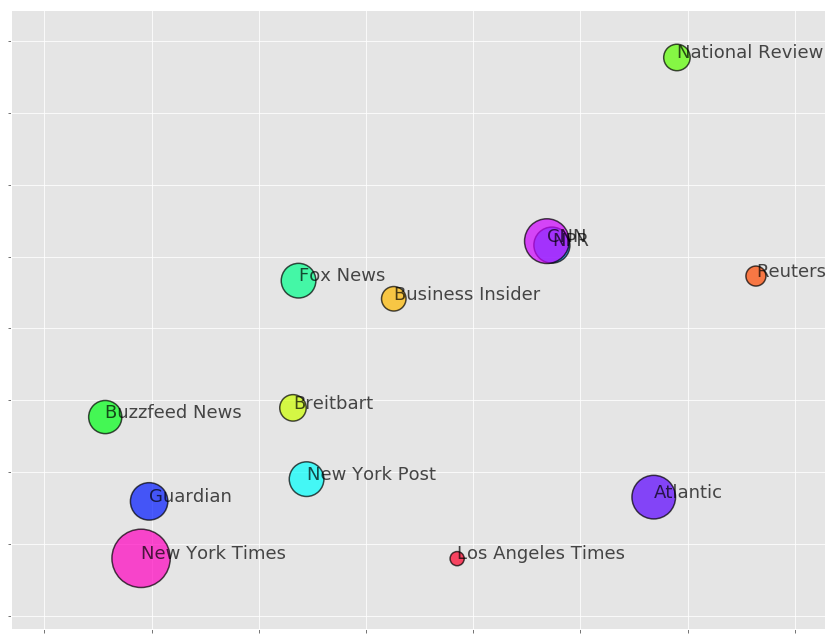

In [51]:
fig, ax = plt.subplots(figsize=(12, 9))

colors = [i for i in range(len(groups.index))]

ax.scatter(groups['x'], groups['y'], c=colors, 
            s=groups['count']*100, linewidths=1.5, alpha=0.7,
            edgecolors='k', cmap=plt.cm.gist_rainbow,
            );

for i, txt in enumerate(groups.index):
    ax.annotate(txt, (groups['x'][i], groups['y'][i]),
                fontsize=18, alpha=0.7);
ax.set_xticklabels(['']);
ax.set_yticklabels(['']);
plt.tight_layout()